In [60]:
# Import libraries
# LSTM for EURUSD prices from 
# https://finance.yahoo.com/quote/EURUSD%3DX/history?period1=1070236800&period2=1583366400&interval=1mo&filter=history&frequency=1mo
# Data is on my GitHub and will be downloaded in the next step
import numpy
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import mplfinance as mpf
%matplotlib notebook

In [61]:
url = 'https://raw.githubusercontent.com/DataScientist2807/RNN/master/EURUSD.csv'
df = pd.read_csv(url, error_bad_lines=False)

In [62]:
# Length of dataset is 148. We have 148 prices for Open, High, Low and Close
len(df)

148

In [63]:
# We first have a look at the data with head and tail commands
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-01-01,1.460110,1.559284,1.437298,1.486503,1.486503,0
1,2008-02-01,1.486591,1.557099,1.445191,1.519203,1.519203,0
2,2008-03-01,1.518395,1.590306,0.072902,1.575796,1.575796,0
3,2008-04-01,1.561695,1.601307,1.551711,1.562207,1.562207,0
4,2008-05-01,1.547796,1.581803,1.537090,1.555791,1.555791,0


In [64]:
# The last date look different then the others. It is the date when I programmed this. 
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
143,2019-12-01,1.101910,1.124101,1.100376,1.120230,1.120230,0
144,2020-01-01,1.122083,1.122838,1.099324,1.102913,1.102913,0
145,2020-02-01,1.109609,1.109609,1.077958,1.103000,1.103000,0
146,2020-03-01,1.102809,1.120750,1.102809,1.114405,1.114405,0
147,2020-03-05,1.113586,1.122083,1.112471,1.120448,1.120448,0


In [65]:
# We will drop it to be consistent. That every first day of each month is the baseline.
df = df[:-1]
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
142,2019-11-01,1.115611,1.119445,1.098286,1.102000,1.102000,0
143,2019-12-01,1.101910,1.124101,1.100376,1.120230,1.120230,0
144,2020-01-01,1.122083,1.122838,1.099324,1.102913,1.102913,0
145,2020-02-01,1.109609,1.109609,1.077958,1.103000,1.103000,0
146,2020-03-01,1.102809,1.120750,1.102809,1.114405,1.114405,0


<h2>Visualization with pyplot</h2>

In [66]:
# Types for dataset looks fine although Date shouldn't be an object and more datetime type
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [67]:
fig = go.Figure(data=go.Ohlc(x=df['Date'],
                    open=df['Open'],
                    high=df['High'],
                    low=df['Low'],
                    close=df['Close']))
fig.show()

In [10]:
# We see some prices here who are not fitting in the whole picture. 
# Luckily the plot is quite innovative and when we do a mouse-over we can see the date and prices
# We probably could automize to change prices of outlieres but this we won't do here (only 2 prices to change)
# We will change the prices manually. More specifically we will take the new price as the price one month before

<h3>Remove price outliers</h3> 

In [18]:
# Outliers in March 2018 (Low) and Jan 2012 (Low)
print(df.loc[df['Date'] == "2008-03-01"])
print(df.loc[df['Date'] == "2012-01-01"])

         Date      Open      High       Low     Close  Adj Close  Volume
2  2008-03-01  1.518395  1.590306  0.072902  1.575796   1.575796       0
          Date      Open      High       Low     Close  Adj Close  Volume
48  2012-01-01  1.296092  1.323399  0.760572  1.313957   1.313957       0


In [19]:
# Clearly we see both outliers in Low price with 0.072902 and 0.760572

In [20]:
# Let's get the prices for previous month for both outliers
price_outlier1 = df[df.Date == "2008-02-01"]["Low"].values[0]
price_outlier2 = df[df.Date == "2011-12-01"]["Low"].values[0]
print("Previous price for outlier 1 is " + str(price_outlier1) + " and for outlier 2 is " + str(price_outlier2))

Previous price for outlier 1 is 1.445191 and for outlier 2 is 1.286124


In [21]:
# We will change now both prices to previous prices
df.loc[df['Date'] == "2008-03-01", 'Low'] = price_outlier1
df.loc[df['Date'] == "2012-01-01", 'Low'] = price_outlier2

In [22]:
# Outliers in March 2018 (Low) and Jan 2012 (Low)
print(df.loc[df['Date'] == "2008-03-01"])
print(df.loc[df['Date'] == "2012-01-01"])

         Date      Open      High       Low     Close  Adj Close  Volume
2  2008-03-01  1.518395  1.590306  1.445191  1.575796   1.575796       0
          Date      Open      High       Low     Close  Adj Close  Volume
48  2012-01-01  1.296092  1.323399  1.286124  1.313957   1.313957       0


In [23]:
# Looks good, let's check the candlestick chart
fig = go.Figure(data=go.Ohlc(x=df['Date'],
                    open=df['Open'],
                    high=df['High'],
                    low=df['Low'],
                    close=df['Close']))
fig.show()

In [17]:
# Looks much better right? As we can see both outliers are eliminated and we can continue.

In [24]:
# One important thing before we start is to set the seed for reproducibility
numpy.random.seed(1234)

In [36]:
# We will use the four columns of price state and put them into different dataframes
df_open = df[["Open"]]
df_high = df[["High"]]
df_low = df[["Low"]]
df_close = df[["Close"]]
# Example
df_high.head()

,High
0,1.559284
1,1.557099
2,1.590306
3,1.601307
4,1.581803


In [37]:
# Our algorithm needs to understand all these values hence we transform them into values or floats to be specifically.
# Although we can see from above that it is already a type float jupyter notebook is not showing '' by default.

In [38]:
df_open, df_high, df_low, df_close  = df_open.values, df_high.values, df_low.values, df_close.values
df_open, df_high, df_low, df_close = df_open.astype('float32'), df_high.astype('float32'), df_low.astype('float32'), df_close.astype('float32') 

In [39]:
# Next we will normalize the data 
sc = MinMaxScaler(feature_range=(0, 1))
df_open, df_high, df_low, df_close = sc.fit_transform(df_open), sc.fit_transform(df_high), sc.fit_transform(df_low), sc.fit_transform(df_close)

In [40]:
# Split data into trainset and testset
# Hence all prices have the same lenth we only have to write the size for trainset and testset once
train_size = int(len(df_open) * 2/3)
test_size = len(df_open) - train_size
# Now the split:
train_open, test_open = df_open[0:train_size,:], df_open[train_size:len(df_open),:]
train_high, test_high = df_high[0:train_size,:], df_high[train_size:len(df_high),:]
train_low, test_low = df_low[0:train_size,:], df_low[train_size:len(df_low),:]
train_close, test_close = df_close[0:train_size,:], df_close[train_size:len(df_close),:]

In [41]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [42]:
# Reshape into X=t and Y=t+1
look_back = 1
trainX_open, trainY_open = create_dataset(train_open, look_back)
testX_open, testY_open = create_dataset(test_open, look_back)
trainX_high, trainY_high = create_dataset(train_high, look_back)
testX_high, testY_high = create_dataset(test_high, look_back)
trainX_low, trainY_low = create_dataset(train_low, look_back)
testX_low, testY_low = create_dataset(test_low, look_back)
trainX_close, trainY_close = create_dataset(train_close, look_back)
testX_close, testY_close = create_dataset(test_close, look_back)

In [43]:
# reshape input to be [samples, time steps, features]
trainX_open = numpy.reshape(trainX_open, (trainX_open.shape[0], 1, trainX_open.shape[1]))
testX_open = numpy.reshape(testX_open, (testX_open.shape[0], 1, testX_open.shape[1]))
trainX_high = numpy.reshape(trainX_high, (trainX_high.shape[0], 1, trainX_high.shape[1]))
testX_high = numpy.reshape(testX_high, (testX_high.shape[0], 1, testX_high.shape[1]))
trainX_low = numpy.reshape(trainX_low, (trainX_low.shape[0], 1, trainX_low.shape[1]))
testX_low = numpy.reshape(testX_low, (testX_low.shape[0], 1, testX_low.shape[1]))
trainX_close = numpy.reshape(trainX_close, (trainX_close.shape[0], 1, trainX_close.shape[1]))
testX_close = numpy.reshape(testX_close, (testX_close.shape[0], 1, testX_close.shape[1]))

<h2>Define LSTM</h2>

In [44]:
def get_LSTM(trainX, trainY, epochsval, batchsize, verboseval):
    # Create and fit the LSTM
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=epochsval, batch_size=batchsize, verbose=verboseval)
    return model

<h2>LSTM Prediction for Open Price</h2>

In [45]:
scoreOpen = get_LSTM(trainX_open, trainY_open, 10, 1, 2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 0s - loss: 0.2327
Epoch 2/10
 - 0s - loss: 0.1175
Epoch 3/10
 - 0s - loss: 0.0532
Epoch 4/10
 - 0s - loss: 0.0318
Epoch 5/10
 - 0s - loss: 0.0268
Epoch 6/10
 - 0s - loss: 0.0252
Epoch 7/10
 - 0s - loss: 0.0239
Epoch 8/10
 - 0s - loss: 0.0226
Epoch 9/10
 - 0s - loss: 0.0212
Epoch 10/10
 - 0s - loss: 0.0197


<h2>LSTM Prediction for High Price</h2>

In [46]:
scoreHigh = get_LSTM(trainX_high, trainY_high, 10, 1, 2)

Epoch 1/10
 - 0s - loss: 0.3052
Epoch 2/10
 - 0s - loss: 0.1537
Epoch 3/10
 - 0s - loss: 0.0718
Epoch 4/10
 - 0s - loss: 0.0392
Epoch 5/10
 - 0s - loss: 0.0301
Epoch 6/10
 - 0s - loss: 0.0273
Epoch 7/10
 - 0s - loss: 0.0257
Epoch 8/10
 - 0s - loss: 0.0243
Epoch 9/10
 - 0s - loss: 0.0227
Epoch 10/10
 - 0s - loss: 0.0212


<h2>LSTM Prediction for Low Price</h2>

In [47]:
scoreLow = get_LSTM(trainX_low, trainY_low, 10, 1, 2)

Epoch 1/10
 - 1s - loss: 0.1557
Epoch 2/10
 - 0s - loss: 0.0667
Epoch 3/10
 - 0s - loss: 0.0283
Epoch 4/10
 - 0s - loss: 0.0198
Epoch 5/10
 - 0s - loss: 0.0180
Epoch 6/10
 - 0s - loss: 0.0168
Epoch 7/10
 - 0s - loss: 0.0158
Epoch 8/10
 - 0s - loss: 0.0144
Epoch 9/10
 - 0s - loss: 0.0133
Epoch 10/10
 - 0s - loss: 0.0123


<h2>LSTM Prediction for Close Price</h2>

In [48]:
scoreClose = get_LSTM(trainX_close, trainY_close, 10, 1, 2)

Epoch 1/10
 - 1s - loss: 0.3322
Epoch 2/10
 - 0s - loss: 0.1999
Epoch 3/10
 - 0s - loss: 0.1145
Epoch 4/10
 - 0s - loss: 0.0659
Epoch 5/10
 - 0s - loss: 0.0473
Epoch 6/10
 - 0s - loss: 0.0417
Epoch 7/10
 - 0s - loss: 0.0384
Epoch 8/10
 - 0s - loss: 0.0364
Epoch 9/10
 - 0s - loss: 0.0344
Epoch 10/10
 - 0s - loss: 0.0326


<h3>Predictions Open, High, Low, Close</h3>

In [49]:
trainPredictOpen = scoreOpen.predict(trainX_open)
testPredictOpen = scoreOpen.predict(testX_open)
trainPredictHigh = scoreHigh.predict(trainX_high)
testPredictHigh = scoreHigh.predict(testX_high)
trainPredictLow = scoreLow.predict(trainX_low)
testPredictLow = scoreLow.predict(testX_low)
trainPredictClose = scoreClose.predict(trainX_close)
testPredictClose = scoreClose.predict(testX_close)

In [50]:
def invpred(price):
    val = sc.inverse_transform(price)
    return val

<h3>Invert prediction values Open Price</h3>

In [51]:
trainPredictOpen = sc.inverse_transform(trainPredictOpen)
trainYOpen = sc.inverse_transform([trainY_open])
testPredictOpen = sc.inverse_transform(testPredictOpen)
testYOpen = sc.inverse_transform([testY_open])

<h3>Invert prediction values High Price</h3>

In [52]:
trainPredictHigh = sc.inverse_transform(trainPredictHigh)
trainYHigh = sc.inverse_transform([trainY_high])
testPredictHigh = sc.inverse_transform(testPredictHigh)
testYHigh = sc.inverse_transform([testY_high])

<h3>Invert prediction values Low Price</h3>

In [53]:
trainPredictLow = sc.inverse_transform(trainPredictLow)
trainYLow = sc.inverse_transform([trainY_low])
testPredictLow = sc.inverse_transform(testPredictLow)
testYLow = sc.inverse_transform([testY_low])

<h3>Invert prediction values Close Price</h3>

In [54]:
trainPredictClose = sc.inverse_transform(trainPredictClose)
trainYClose = sc.inverse_transform([trainY_close])
testPredictClose = sc.inverse_transform(testPredictClose)
testYClose = sc.inverse_transform([testY_close])

<h3>Invert prediction values Close Price</h3>

In [55]:
def score_RMSE(trainY, trainPredict):
    return math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))

<h3>Show RMSE results</h3>

In [56]:
report = pd.DataFrame(
{"Train": [format(score_RMSE(trainYOpen, trainPredictOpen), '.2f') , format(score_RMSE(trainYHigh, trainPredictHigh), '.2f'), format(score_RMSE(trainYLow, trainPredictLow), '.2f'), format(score_RMSE(trainYClose, trainPredictClose), '.2f')],
"Test": [format(score_RMSE(testYOpen, testPredictOpen), '.2f'), format(score_RMSE(testYHigh, testPredictHigh), '.2f'), format(score_RMSE(testYLow, testPredictLow), '.2f'), format(score_RMSE(testYClose, testPredictClose), '.2f') ]},
index = ["Open", "High", "Low", "Close"])
print(report)

      Train  Test
Open   0.07  0.11
High   0.07  0.13
Low    0.06  0.08
Close  0.09  0.15


In [57]:
# Shift train predictions for plotting
trainPredictPlotOpen = numpy.empty_like(df_open)
trainPredictPlotOpen[:, :] = numpy.nan
trainPredictPlotOpen[look_back:len(trainPredictOpen)+look_back, :] = trainPredictOpen

trainPredictPlotHigh = numpy.empty_like(df_high)
trainPredictPlotHigh[:, :] = numpy.nan
trainPredictPlotHigh[look_back:len(trainPredictHigh)+look_back, :] = trainPredictHigh

trainPredictPlotLow = numpy.empty_like(df_low)
trainPredictPlotLow[:, :] = numpy.nan
trainPredictPlotLow[look_back:len(trainPredictLow)+look_back, :] = trainPredictLow

trainPredictPlotClose = numpy.empty_like(df_close)
trainPredictPlotClose[:, :] = numpy.nan
trainPredictPlotClose[look_back:len(trainPredictClose)+look_back, :] = trainPredictClose

# Shift test predictions for plotting
testPredictPlotOpen = numpy.empty_like(df_open)
testPredictPlotOpen[:, :] = numpy.nan
testPredictPlotOpen[len(trainPredictOpen)+(look_back*2)+1:len(df_open)-1, :] = testPredictOpen

testPredictPlotHigh = numpy.empty_like(df_high)
testPredictPlotHigh[:, :] = numpy.nan
testPredictPlotHigh[len(trainPredictHigh)+(look_back*2)+1:len(df_high)-1, :] = testPredictHigh

testPredictPlotLow = numpy.empty_like(df_low)
testPredictPlotLow[:, :] = numpy.nan
testPredictPlotLow[len(trainPredictLow)+(look_back*2)+1:len(df_low)-1, :] = testPredictLow

testPredictPlotClose = numpy.empty_like(df_close)
testPredictPlotClose[:, :] = numpy.nan
testPredictPlotClose[len(trainPredictClose)+(look_back*2)+1:len(df_close)-1, :] = testPredictClose

In [58]:
#df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m')

/Users/marcelbruckmann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



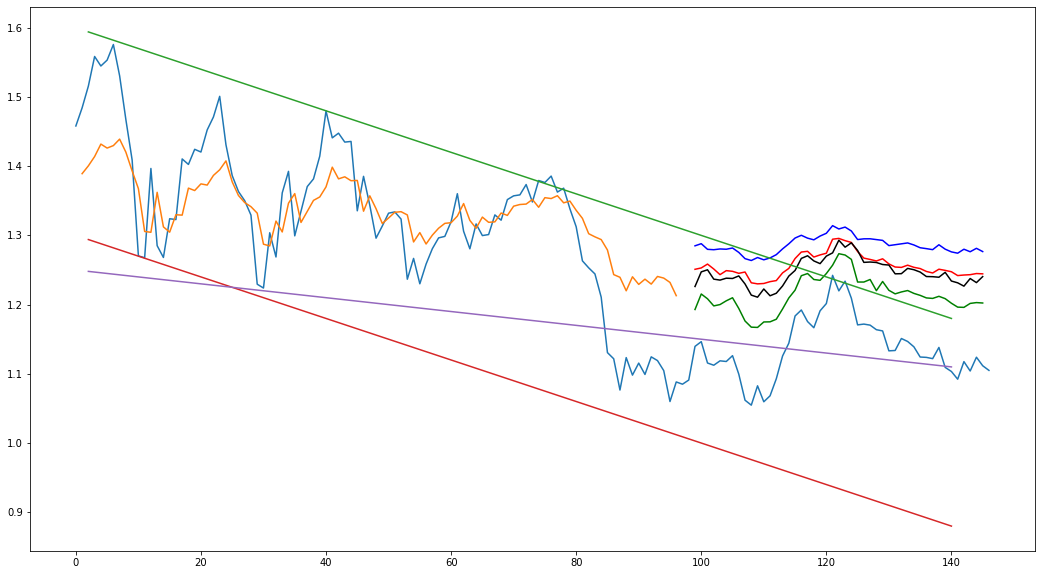

In [59]:
# plot baseline and predictions
import datetime
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(18,10))
ax.plot(sc.inverse_transform(df_open)) # Real Open Price
ax.plot(trainPredictPlotOpen) # Train Open Price
ax.plot(testPredictPlotHigh, 'r-')
ax.plot(testPredictPlotClose, 'b-')
ax.plot(testPredictPlotOpen, 'k-')
ax.plot(testPredictPlotLow, 'g-')
x1 = np.linspace(2,140,50)
y1 = -0.0030*x1+1.6
ax.plot(x1, y1)

x2 = np.linspace(2,140,50)
y2 = -0.0030*x2+1.3
ax.plot(x2, y2)

x3 = np.linspace(2,140,50)
y3 = -0.0010*x3+1.25
ax.plot(x3, y3)
fig.show()

<h3>Conclusion</h3>

We first found two outliers who are really far from the rices surrounded by them. This can be an error by yahoo.com or some big news announced like non-farm payrolls by Federal Reserve. I leave it up to people who read this to check the influences of the outliers. We've set up the LSTM Model to make our predictions on OHLC (Open-High-Low-Close) price. Further we've calculated RMSE (Root Mean Suared Error). Finally we've drawn the nice plot. 
A bit strange is that the arrangement of the colors. E.g. The black color represents the predicted open price and green color the low price prediction. This cannot be. To have some rough predictions under risk probably we can use it. We've also drawn some lines for trend. To get familiar with the topic I would recommend the reader to look up this if it is not understandable. But basically the lines showing the channel where the price could move into the future. We do not have a channel only more also a triangle shown. This triangle usually becomes closer, means the momentum is getting slower. A trader would wait for an outbreak of one of these lines. After breaking a line, the line becomes a resistance line and it is then unlikely that the price moves back. Actually in our plot the price moved back. This is called noise. The price is currently not yet broken and there is a chance that price moves further downwards.

<h3>THANK YOU FOR READING THIS! I HOPE YOU FOUND IT VALUABLE FOR YOU OR YOUR BUSINESS</h3>